In [ ]:
# credit_risk_end_to_end.py
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_auc_score, roc_curve,
    precision_score, recall_score, f1_score, accuracy_score
)
import xgboost as xgb

# File path
data_path = "/content/loan_data_2007_2014.csv"

# Kolom yang dipakai untuk prediksi
selected_columns = [
    "loan_amnt", "term", "int_rate", "installment", "grade", "purpose",
    "emp_length", "home_ownership", "annual_inc", "verification_status",
    "dti", "delinq_2yrs", "inq_last_6mths", "open_acc", "revol_bal",
    "revol_util", "total_acc", "pub_rec", "loan_status"
]

# Load dataset hanya dengan kolom yang dibutuhkan
df = pd.read_csv(data_path, usecols=selected_columns, low_memory=False)

print(df.head())

   loan_amnt        term  int_rate  installment grade emp_length  \
0       5000   36 months     10.65       162.87     B  10+ years   
1       2500   60 months     15.27        59.83     C   < 1 year   
2       2400   36 months     15.96        84.33     C  10+ years   
3      10000   36 months     13.49       339.31     C  10+ years   
4       3000   60 months     12.69        67.79     B     1 year   

  home_ownership  annual_inc verification_status  loan_status         purpose  \
0           RENT     24000.0            Verified   Fully Paid     credit_card   
1           RENT     30000.0     Source Verified  Charged Off             car   
2           RENT     12252.0        Not Verified   Fully Paid  small_business   
3           RENT     49200.0     Source Verified   Fully Paid           other   
4           RENT     80000.0     Source Verified      Current           other   

     dti  delinq_2yrs  inq_last_6mths  open_acc  pub_rec  revol_bal  \
0  27.65          0.0            

In [ ]:
# Melihat ringkasan tipe data, non-null count, dan memory usage
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 19 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   loan_amnt            466285 non-null  int64  
 1   term                 466285 non-null  object 
 2   int_rate             466285 non-null  float64
 3   installment          466285 non-null  float64
 4   grade                466285 non-null  object 
 5   emp_length           445277 non-null  object 
 6   home_ownership       466285 non-null  object 
 7   annual_inc           466281 non-null  float64
 8   verification_status  466285 non-null  object 
 9   loan_status          466285 non-null  object 
 10  purpose              466285 non-null  object 
 11  dti                  466285 non-null  float64
 12  delinq_2yrs          466256 non-null  float64
 13  inq_last_6mths       466256 non-null  float64
 14  open_acc             466256 non-null  float64
 15  pub_rec          

In [ ]:
df

,loan_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc
0,5000,36 months,10.65,162.87,B,10+ years,RENT,24000.0,Verified,Fully Paid,credit_card,27.65,0.0,1.0,3.0,0.0,13648,83.7,9.0
1,2500,60 months,15.27,59.83,C,< 1 year,RENT,30000.0,Source Verified,Charged Off,car,1.00,0.0,5.0,3.0,0.0,1687,9.4,4.0
2,2400,36 months,15.96,84.33,C,10+ years,RENT,12252.0,Not Verified,Fully Paid,small_business,8.72,0.0,2.0,2.0,0.0,2956,98.5,10.0
3,10000,36 months,13.49,339.31,C,10+ years,RENT,49200.0,Source Verified,Fully Paid,other,20.00,0.0,1.0,10.0,0.0,5598,21.0,37.0
4,3000,60 months,12.69,67.79,B,1 year,RENT,80000.0,Source Verified,Current,other,17.94,0.0,0.0,15.0,0.0,27783,53.9,38.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466280,18400,60 months,14.47,432.64,C,4 years,MORTGAGE,110000.0,Source Verified,Current,debt_consolidation,19.85,0.0,2.0,18.0,0.0,23208,77.6,36.0
466281,22000,60 months,19.97,582.50,D,10+ years,MORTGAGE,78000.0,Verified,Charged Off,debt_consolidation,18.45,0.0,5.0,18.0,1.0,18238,46.3,30.0
466282,20700,60 months,16.99,514.34,D,7 years,MORTGAGE,46000.0,Verified,Current,debt_consolidation,25.65,0.0,2.0,18.0,0.0,6688,51.1,43.0
466283,2000,36 months,7.90,62.59,A,3 years,OWN,83000.0,Verified,Fully Paid,credit_card,5.39,3.0,1.0,21.0,0.0,11404,21.5,27.0


In [ ]:
# =========================================
# 1. Data Cleaning & Transformation
# =========================================

# term → angka bulan
df["term"] = df["term"].astype(str).str.extract(r'(\d+)').astype(float)

df

,loan_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc
0,5000,36.0,10.65,162.87,B,10+ years,RENT,24000.0,Verified,Fully Paid,credit_card,27.65,0.0,1.0,3.0,0.0,13648,83.7,9.0
1,2500,60.0,15.27,59.83,C,< 1 year,RENT,30000.0,Source Verified,Charged Off,car,1.00,0.0,5.0,3.0,0.0,1687,9.4,4.0
2,2400,36.0,15.96,84.33,C,10+ years,RENT,12252.0,Not Verified,Fully Paid,small_business,8.72,0.0,2.0,2.0,0.0,2956,98.5,10.0
3,10000,36.0,13.49,339.31,C,10+ years,RENT,49200.0,Source Verified,Fully Paid,other,20.00,0.0,1.0,10.0,0.0,5598,21.0,37.0
4,3000,60.0,12.69,67.79,B,1 year,RENT,80000.0,Source Verified,Current,other,17.94,0.0,0.0,15.0,0.0,27783,53.9,38.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466280,18400,60.0,14.47,432.64,C,4 years,MORTGAGE,110000.0,Source Verified,Current,debt_consolidation,19.85,0.0,2.0,18.0,0.0,23208,77.6,36.0
466281,22000,60.0,19.97,582.50,D,10+ years,MORTGAGE,78000.0,Verified,Charged Off,debt_consolidation,18.45,0.0,5.0,18.0,1.0,18238,46.3,30.0
466282,20700,60.0,16.99,514.34,D,7 years,MORTGAGE,46000.0,Verified,Current,debt_consolidation,25.65,0.0,2.0,18.0,0.0,6688,51.1,43.0
466283,2000,36.0,7.90,62.59,A,3 years,OWN,83000.0,Verified,Fully Paid,credit_card,5.39,3.0,1.0,21.0,0.0,11404,21.5,27.0


In [ ]:

# emp_length → numeric
def emp_length_to_num(x):
    if pd.isna(x):
        return np.nan
    if "10+" in str(x):
        return 10
    if "< 1" in str(x):
        return 0
    digits = ''.join([c for c in str(x) if c.isdigit()])
    return float(digits) if digits else np.nan

df["emp_length"] = df["emp_length"].apply(emp_length_to_num)
df

,loan_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc
0,5000,36.0,10.65,162.87,B,10.0,RENT,24000.0,Verified,Fully Paid,credit_card,27.65,0.0,1.0,3.0,0.0,13648,83.7,9.0
1,2500,60.0,15.27,59.83,C,0.0,RENT,30000.0,Source Verified,Charged Off,car,1.00,0.0,5.0,3.0,0.0,1687,9.4,4.0
2,2400,36.0,15.96,84.33,C,10.0,RENT,12252.0,Not Verified,Fully Paid,small_business,8.72,0.0,2.0,2.0,0.0,2956,98.5,10.0
3,10000,36.0,13.49,339.31,C,10.0,RENT,49200.0,Source Verified,Fully Paid,other,20.00,0.0,1.0,10.0,0.0,5598,21.0,37.0
4,3000,60.0,12.69,67.79,B,1.0,RENT,80000.0,Source Verified,Current,other,17.94,0.0,0.0,15.0,0.0,27783,53.9,38.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466280,18400,60.0,14.47,432.64,C,4.0,MORTGAGE,110000.0,Source Verified,Current,debt_consolidation,19.85,0.0,2.0,18.0,0.0,23208,77.6,36.0
466281,22000,60.0,19.97,582.50,D,10.0,MORTGAGE,78000.0,Verified,Charged Off,debt_consolidation,18.45,0.0,5.0,18.0,1.0,18238,46.3,30.0
466282,20700,60.0,16.99,514.34,D,7.0,MORTGAGE,46000.0,Verified,Current,debt_consolidation,25.65,0.0,2.0,18.0,0.0,6688,51.1,43.0
466283,2000,36.0,7.90,62.59,A,3.0,OWN,83000.0,Verified,Fully Paid,credit_card,5.39,3.0,1.0,21.0,0.0,11404,21.5,27.0


In [ ]:
# loan_status → binary target
good_status = ["Fully Paid", "Current"]
bad_status = ["Charged Off", "Default", "Late (16-30 days)", "Late (31-120 days)"]

df = df[df["loan_status"].isin(good_status + bad_status)]
df["loan_status"] = df["loan_status"].apply(lambda x: 1 if x in good_status else 0)

df

,loan_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc
0,5000,36.0,10.65,162.87,B,10.0,RENT,24000.0,Verified,1,credit_card,27.65,0.0,1.0,3.0,0.0,13648,83.7,9.0
1,2500,60.0,15.27,59.83,C,0.0,RENT,30000.0,Source Verified,0,car,1.00,0.0,5.0,3.0,0.0,1687,9.4,4.0
2,2400,36.0,15.96,84.33,C,10.0,RENT,12252.0,Not Verified,1,small_business,8.72,0.0,2.0,2.0,0.0,2956,98.5,10.0
3,10000,36.0,13.49,339.31,C,10.0,RENT,49200.0,Source Verified,1,other,20.00,0.0,1.0,10.0,0.0,5598,21.0,37.0
4,3000,60.0,12.69,67.79,B,1.0,RENT,80000.0,Source Verified,1,other,17.94,0.0,0.0,15.0,0.0,27783,53.9,38.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466280,18400,60.0,14.47,432.64,C,4.0,MORTGAGE,110000.0,Source Verified,1,debt_consolidation,19.85,0.0,2.0,18.0,0.0,23208,77.6,36.0
466281,22000,60.0,19.97,582.50,D,10.0,MORTGAGE,78000.0,Verified,0,debt_consolidation,18.45,0.0,5.0,18.0,1.0,18238,46.3,30.0
466282,20700,60.0,16.99,514.34,D,7.0,MORTGAGE,46000.0,Verified,1,debt_consolidation,25.65,0.0,2.0,18.0,0.0,6688,51.1,43.0
466283,2000,36.0,7.90,62.59,A,3.0,OWN,83000.0,Verified,1,credit_card,5.39,3.0,1.0,21.0,0.0,11404,21.5,27.0


In [ ]:
# =========================================
# 2. Feature Creation
# =========================================
df["income_to_loan_ratio"] = df["annual_inc"] / df["loan_amnt"]
df["installment_to_income"] = df["installment"] / (df["annual_inc"] / 12)

df

,loan_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,...,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,income_to_loan_ratio,installment_to_income
0,5000,36.0,10.65,162.87,B,10.0,RENT,24000.0,Verified,1,...,27.65,0.0,1.0,3.0,0.0,13648,83.7,9.0,4.800000,0.081435
1,2500,60.0,15.27,59.83,C,0.0,RENT,30000.0,Source Verified,0,...,1.00,0.0,5.0,3.0,0.0,1687,9.4,4.0,12.000000,0.023932
2,2400,36.0,15.96,84.33,C,10.0,RENT,12252.0,Not Verified,1,...,8.72,0.0,2.0,2.0,0.0,2956,98.5,10.0,5.105000,0.082595
3,10000,36.0,13.49,339.31,C,10.0,RENT,49200.0,Source Verified,1,...,20.00,0.0,1.0,10.0,0.0,5598,21.0,37.0,4.920000,0.082759
4,3000,60.0,12.69,67.79,B,1.0,RENT,80000.0,Source Verified,1,...,17.94,0.0,0.0,15.0,0.0,27783,53.9,38.0,26.666667,0.010169
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466280,18400,60.0,14.47,432.64,C,4.0,MORTGAGE,110000.0,Source Verified,1,...,19.85,0.0,2.0,18.0,0.0,23208,77.6,36.0,5.978261,0.047197
466281,22000,60.0,19.97,582.50,D,10.0,MORTGAGE,78000.0,Verified,0,...,18.45,0.0,5.0,18.0,1.0,18238,46.3,30.0,3.545455,0.089615
466282,20700,60.0,16.99,514.34,D,7.0,MORTGAGE,46000.0,Verified,1,...,25.65,0.0,2.0,18.0,0.0,6688,51.1,43.0,2.222222,0.134176
466283,2000,36.0,7.90,62.59,A,3.0,OWN,83000.0,Verified,1,...,5.39,3.0,1.0,21.0,0.0,11404,21.5,27.0,41.500000,0.009049


In [ ]:
# Jumlah missing per kolom
print(df.isnull().sum())

# Total missing di seluruh X
print("Total missing di df:", df.isnull().sum().sum())

# Cek kolom mana yang ada missing value
print("Kolom dengan missing value:", df.columns[df.isnull().any()].tolist())

loan_amnt                    0
term                         0
int_rate                     0
installment                  0
grade                        0
emp_length               20872
home_ownership               0
annual_inc                   0
verification_status          0
loan_status                  0
purpose                      0
dti                          0
delinq_2yrs                  0
inq_last_6mths               0
open_acc                     0
pub_rec                      0
revol_bal                    0
revol_util                 298
total_acc                    0
income_to_loan_ratio         0
installment_to_income        0
dtype: int64
Total missing di df: 21170
Kolom dengan missing value: ['emp_length', 'revol_util']


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 460390 entries, 0 to 466284
Data columns (total 21 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   loan_amnt              460390 non-null  int64  
 1   term                   460390 non-null  float64
 2   int_rate               460390 non-null  float64
 3   installment            460390 non-null  float64
 4   grade                  460390 non-null  object 
 5   emp_length             439518 non-null  float64
 6   home_ownership         460390 non-null  object 
 7   annual_inc             460390 non-null  float64
 8   verification_status    460390 non-null  object 
 9   loan_status            460390 non-null  int64  
 10  purpose                460390 non-null  object 
 11  dti                    460390 non-null  float64
 12  delinq_2yrs            460390 non-null  float64
 13  inq_last_6mths         460390 non-null  float64
 14  open_acc               460390 non-null  f

In [ ]:
# Mapping grade → angka ordinal
grade_mapping = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7}
df["grade"] = df["grade"].map(grade_mapping)

# =========================================
# 3. Feature Groups
# =========================================
num_features = [
    "loan_amnt", "term", "int_rate", "installment", "emp_length", "annual_inc",
    "dti", "delinq_2yrs", "inq_last_6mths", "open_acc", "revol_bal",
    "revol_util", "total_acc", "pub_rec", "income_to_loan_ratio", "installment_to_income", "grade"
]

cat_features = ["home_ownership", "purpose", "verification_status"]

# =========================================
# 4. Preprocessing Pipelines
# =========================================
# Numerik → imputasi median + scaling
num_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Kategorikal → imputasi modus + OneHotEncoding
cat_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# Gabungkan
preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_transformer, num_features),
        ("cat", cat_transformer, cat_features)
    ]
)


In [ ]:
# =========================================
# 5. Pisahkan X dan y
# =========================================
X = df[num_features + cat_features]
y = df["loan_status"]

# Fit & transform
X_processed = preprocessor.fit_transform(X)

# Ambil nama kolom hasil encoding kategorikal
encoded_cols = preprocessor.named_transformers_["cat"]["onehot"].get_feature_names_out(cat_features)
all_feature_names = num_features + list(encoded_cols)

# Kalau X_processed sparse → konversi dulu
if hasattr(X_processed, "toarray"):
    X_array = X_processed.toarray()
else:
    X_array = X_processed

# Buat DataFrame
X_df = pd.DataFrame(X_array, columns=all_feature_names)

# Cek missing values
print("Total missing di X_df:", X_df.isnull().sum().sum())
print("Missing per kolom:\n", X_df.isnull().sum())


Total missing di X_df: 0
Missing per kolom:
 loan_amnt                              0
term                                   0
int_rate                               0
installment                            0
emp_length                             0
annual_inc                             0
dti                                    0
delinq_2yrs                            0
inq_last_6mths                         0
open_acc                               0
revol_bal                              0
revol_util                             0
total_acc                              0
pub_rec                                0
income_to_loan_ratio                   0
installment_to_income                  0
grade                                  0
home_ownership_ANY                     0
home_ownership_MORTGAGE                0
home_ownership_NONE                    0
home_ownership_OTHER                   0
home_ownership_OWN                     0
home_ownership_RENT                    0
purpose_car 

In [ ]:
X_df

,loan_amnt,term,int_rate,installment,emp_length,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,...,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified
0,-1.127043,-0.616710,-0.725243,-1.108095,1.128157,-0.897908,1.328142,-0.356759,0.207709,-1.644664,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,-1.428830,1.621509,0.333851,-1.531520,-1.695353,-0.788592,-2.067429,-0.356759,4.064459,-1.644664,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-1.440901,-0.616710,0.492027,-1.430842,1.128157,-1.111948,-1.083797,-0.356759,1.171896,-1.845477,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,-0.523469,-0.616710,-0.074198,-0.383044,1.128157,-0.438781,0.353428,-0.356759,0.207709,-0.238969,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,-1.368472,1.621509,-0.257591,-1.498810,-1.413002,0.122374,0.090956,-0.356759,-0.756478,0.765099,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
460385,0.490535,1.621509,0.150458,0.000480,-0.565949,0.668953,0.334316,-0.356759,1.171896,1.367540,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
460386,0.925108,1.621509,1.411283,0.616305,1.128157,0.085935,0.155937,-0.356759,4.064459,1.367540,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
460387,0.768179,1.621509,0.728145,0.336213,0.281104,-0.497083,1.073315,-0.356759,1.171896,1.367540,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
460388,-1.489187,-0.616710,-1.355656,-1.520178,-0.848300,0.177032,-1.508084,3.411063,0.207709,1.969980,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
y

,loan_status
0,1
1,0
2,1
3,1
4,1
...,...
466280,1
466281,0
466282,1
466283,1


In [ ]:
# Cek missing values
print("Total missing di y:", y.isnull().sum().sum())
print("Missing per kolom:\n", y.isnull().sum())

Total missing di y: 0
Missing per kolom:
 0


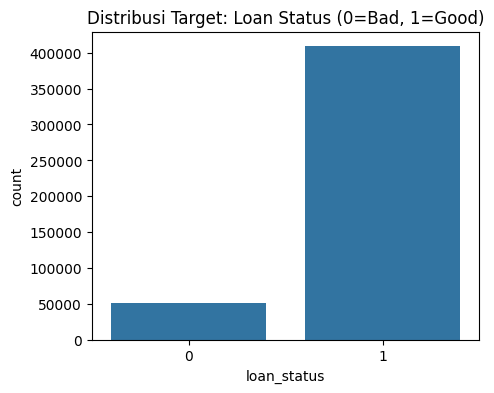

loan_status
1    0.888301
0    0.111699
Name: proportion, dtype: float64

Missing value ratio per column:
 emp_length    0.045335
revol_util    0.000647
dtype: float64


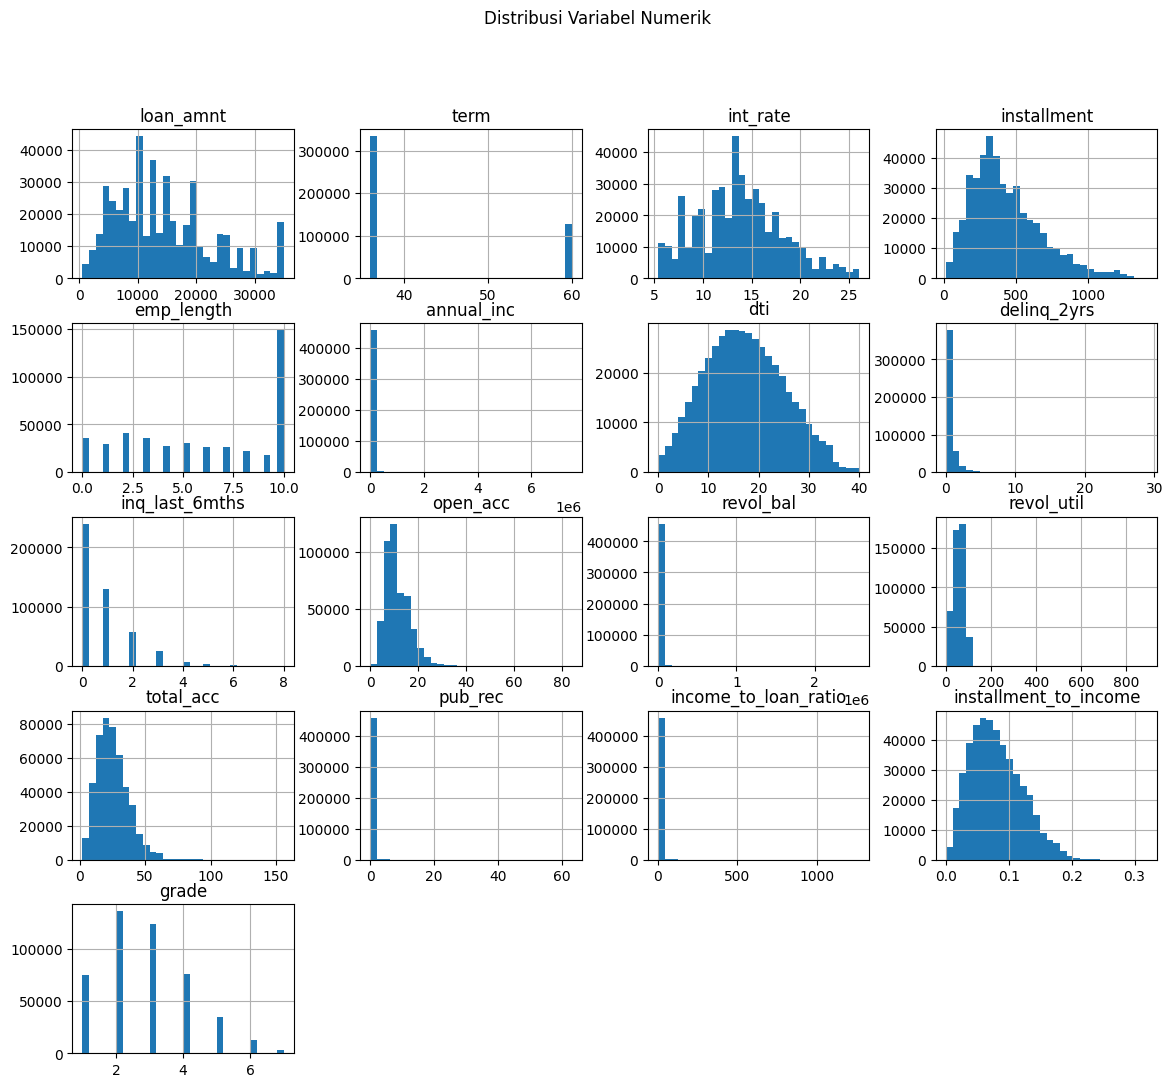

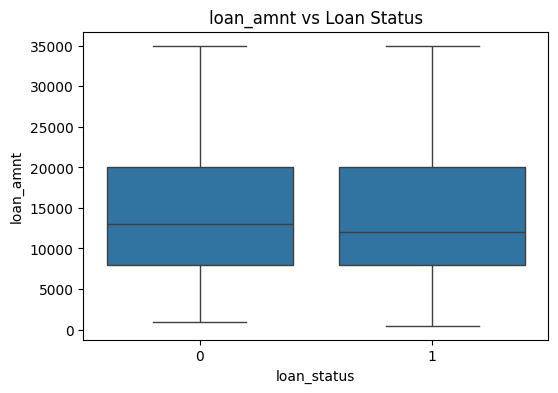

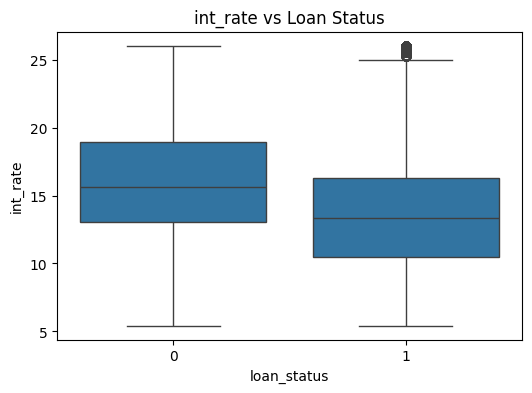

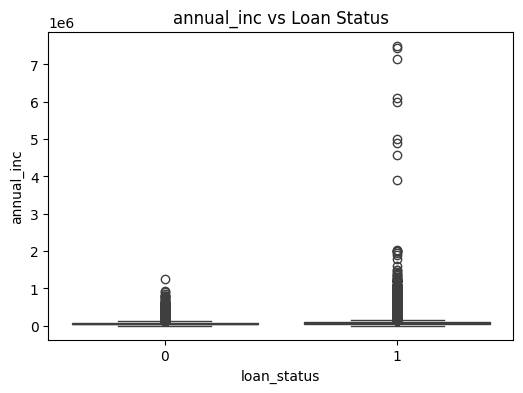

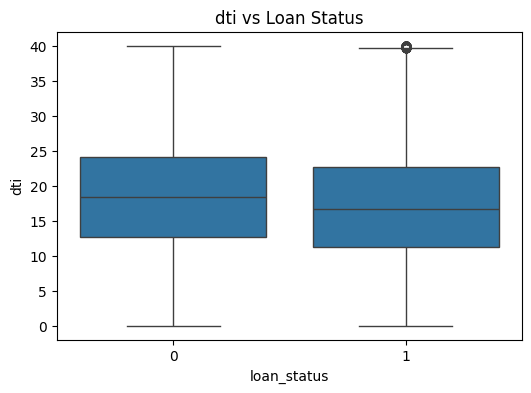

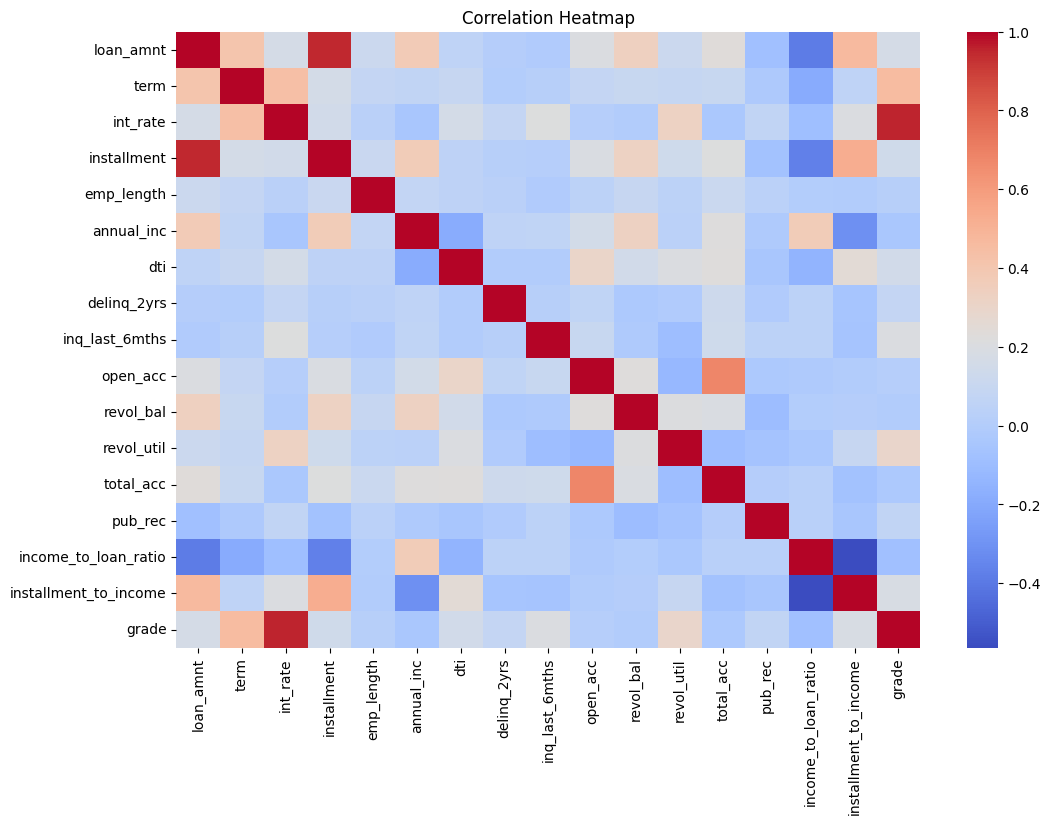

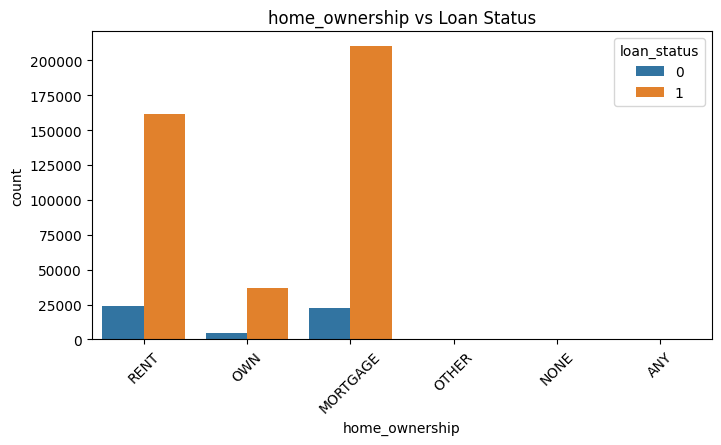

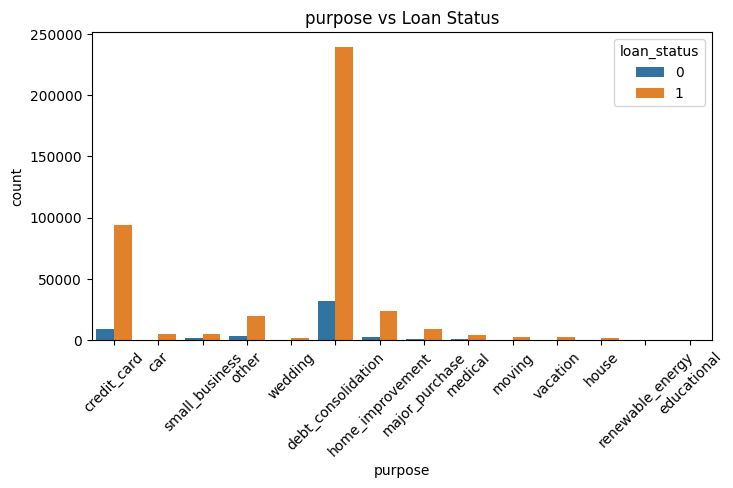

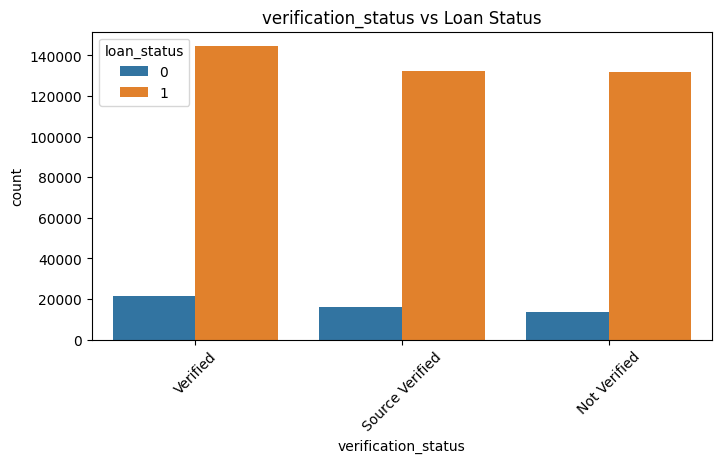

In [ ]:
# ===============================
# Exploratory Data Analysis (EDA)
# ===============================

import matplotlib.pyplot as plt
import seaborn as sns

# 1. Distribusi Target
plt.figure(figsize=(5,4))
sns.countplot(x="loan_status", data=df)
plt.title("Distribusi Target: Loan Status (0=Bad, 1=Good)")
plt.show()

print(df["loan_status"].value_counts(normalize=True))

# 2. Missing values check
missing = df.isnull().mean().sort_values(ascending=False)
print("\nMissing value ratio per column:\n", missing[missing > 0])

# 3. Distribusi variabel numerik
df[num_features].hist(figsize=(14,12), bins=30)
plt.suptitle("Distribusi Variabel Numerik")
plt.show()

# 4. Boxplot untuk melihat perbedaan fitur numerik terhadap target
for col in ["loan_amnt", "int_rate", "annual_inc", "dti"]:
    plt.figure(figsize=(6,4))
    sns.boxplot(x="loan_status", y=col, data=df)
    plt.title(f"{col} vs Loan Status")
    plt.show()

# 5. Korelasi antar variabel numerik
plt.figure(figsize=(12,8))
sns.heatmap(df[num_features].corr(), annot=False, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

# 6. Categorical variable vs target
for col in cat_features:
    plt.figure(figsize=(8,4))
    sns.countplot(x=col, hue="loan_status", data=df)
    plt.title(f"{col} vs Loan Status")
    plt.xticks(rotation=45)
    plt.show()

In [ ]:
# 7. Train/Test split (stratify)
# -------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_df, y, test_size=0.2, random_state=42, stratify=y
)
print("Train/Test sizes:", X_train.shape, X_test.shape)

Train/Test sizes: (368312, 40) (92078, 40)


In [ ]:
# Get feature names after preprocessing
def get_feature_names(ct, num_feats, cat_feats):
    num_names = num_feats
    cat_pipe = ct.named_transformers_["cat"]
    if hasattr(cat_pipe.named_steps["onehot"], "get_feature_names_out"):
        cat_names = list(cat_pipe.named_steps["onehot"].get_feature_names_out(cat_feats))
    else:
        enc = cat_pipe.named_steps["onehot"]
        cat_names = []
        for i, col in enumerate(cat_feats):
            cats = enc.categories_[i]
            cat_names += [f"{col}_{c}" for c in cats]
    return num_names + cat_names

feature_names = get_feature_names(preprocessor, num_features, cat_features)
print("Jumlah fitur akhir:", len(feature_names))

Jumlah fitur akhir: 40


In [ ]:
# -------------------------
# Train 3 models (LR, RF, XGB)
# -------------------------
# For XGBoost, compute scale_pos_weight = neg/pos to help imbalance
pos = sum(y_train==1)
neg = sum(y_train==0)
scale_pos_weight = neg/pos if pos>0 else 1.0
print("train pos/neg:", pos, neg, "scale_pos_weight:", scale_pos_weight)

models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=200, class_weight="balanced", random_state=42),
    "XGBoost": xgb.XGBClassifier(n_estimators=200, use_label_encoder=False, eval_metric="logloss",
                                scale_pos_weight=scale_pos_weight, random_state=42)
}

results = {}
for name, model in models.items():
    print(f"\nTraining {name} ...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    # For models that have predict_proba:
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:,1]
    else:
        # fallback (rare)
        y_proba = model.decision_function(X_test)
        y_proba = (y_proba - y_proba.min())/(y_proba.max()-y_proba.min())
    # metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    auc = roc_auc_score(y_test, y_proba)
    results[name] = {"model":model, "y_pred":y_pred, "y_proba":y_proba,
                     "accuracy":acc, "precision":prec, "recall":rec, "f1":f1, "auc":auc}
    print(f"{name} -- Acc:{acc:.4f} Prec:{prec:.4f} Rec:{rec:.4f} F1:{f1:.4f} AUC:{auc:.4f}")

train pos/neg: 327172 41140 scale_pos_weight: 0.12574425684349516

Training LogisticRegression ...
LogisticRegression -- Acc:0.6332 Prec:0.9310 Rec:0.6341 F1:0.7544 AUC:0.6794

Training RandomForest ...
RandomForest -- Acc:0.8883 Prec:0.8883 Rec:1.0000 F1:0.9408 AUC:0.6690

Training XGBoost ...
XGBoost -- Acc:0.6575 Prec:0.9284 Rec:0.6658 F1:0.7755 AUC:0.6798



Model: LogisticRegression
              precision    recall  f1-score   support

           0     0.1771    0.6260    0.2760     10285
           1     0.9310    0.6341    0.7544     81793

    accuracy                         0.6332     92078
   macro avg     0.5540    0.6301    0.5152     92078
weighted avg     0.8467    0.6332    0.7010     92078



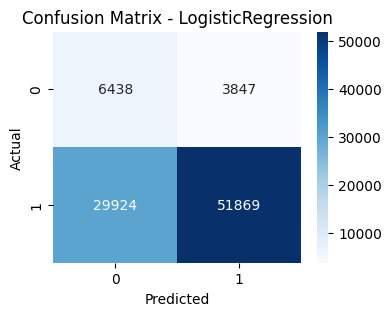

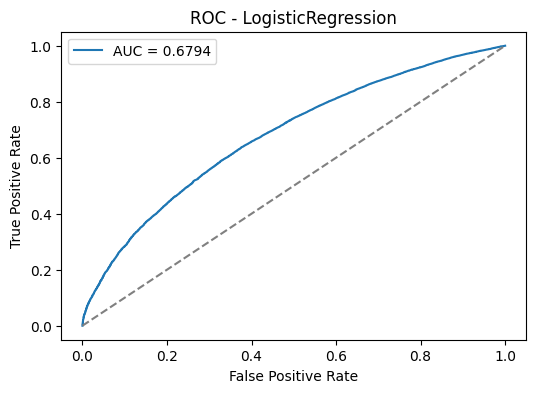


Model: RandomForest
              precision    recall  f1-score   support

           0     0.4000    0.0002    0.0004     10285
           1     0.8883    1.0000    0.9408     81793

    accuracy                         0.8883     92078
   macro avg     0.6442    0.5001    0.4706     92078
weighted avg     0.8338    0.8883    0.8358     92078



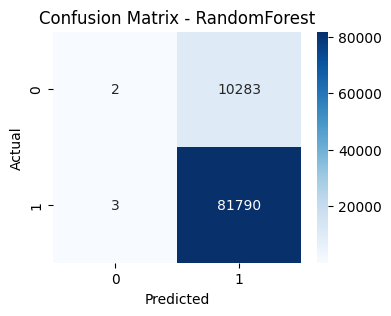

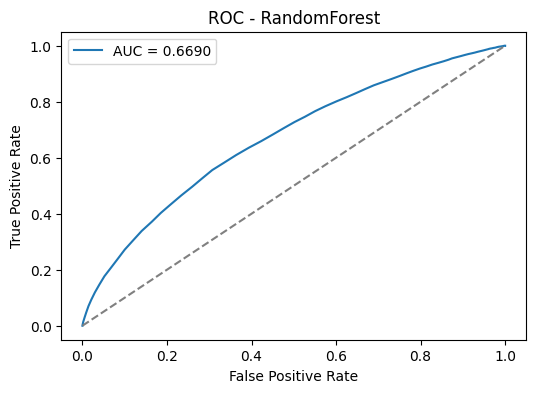


Model: XGBoost
              precision    recall  f1-score   support

           0     0.1821    0.5918    0.2785     10285
           1     0.9284    0.6658    0.7755     81793

    accuracy                         0.6575     92078
   macro avg     0.5553    0.6288    0.5270     92078
weighted avg     0.8451    0.6575    0.7200     92078



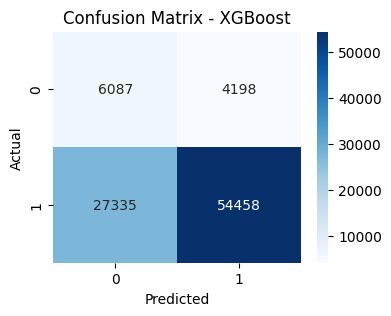

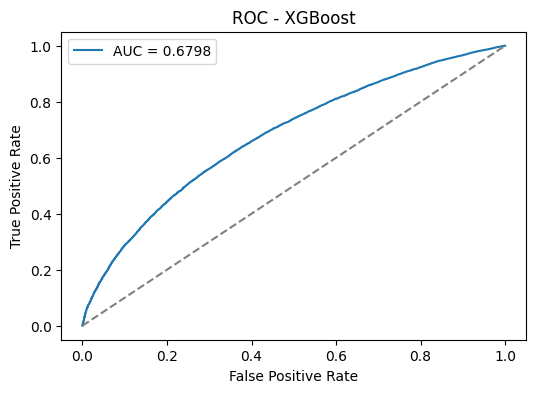

In [ ]:
# -------------------------
# 10. Evaluation plots & reports
# -------------------------
def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.title(title)
    plt.show()

def plot_roc(y_true, y_proba, title):
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    aucv = roc_auc_score(y_true, y_proba)
    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, label=f"AUC = {aucv:.4f}")
    plt.plot([0,1],[0,1],"--", color="gray")
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate"); plt.title(title)
    plt.legend(); plt.show()

for name, r in results.items():
    print("\n========================")
    print("Model:", name)
    print(classification_report(y_test, r["y_pred"], digits=4))
    plot_confusion(y_test, r["y_pred"], f"Confusion Matrix - {name}")
    plot_roc(y_test, r["y_proba"], f"ROC - {name}")


Top features - RandomForest


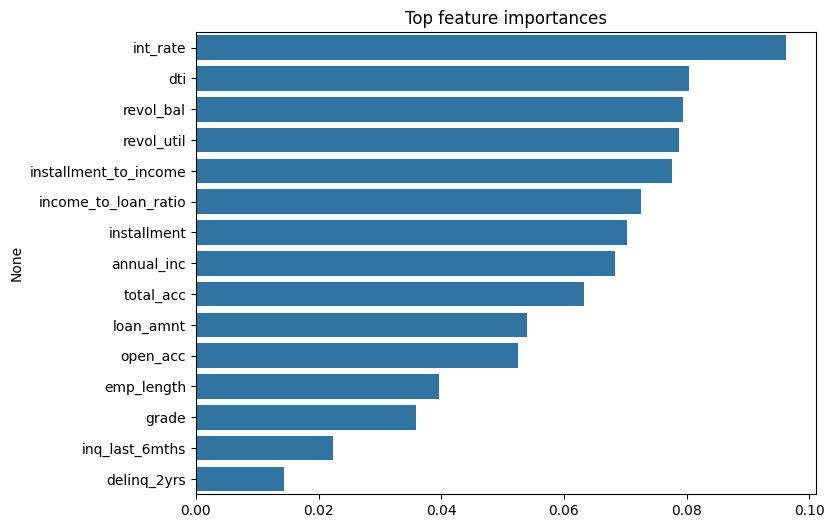


Top features - XGBoost


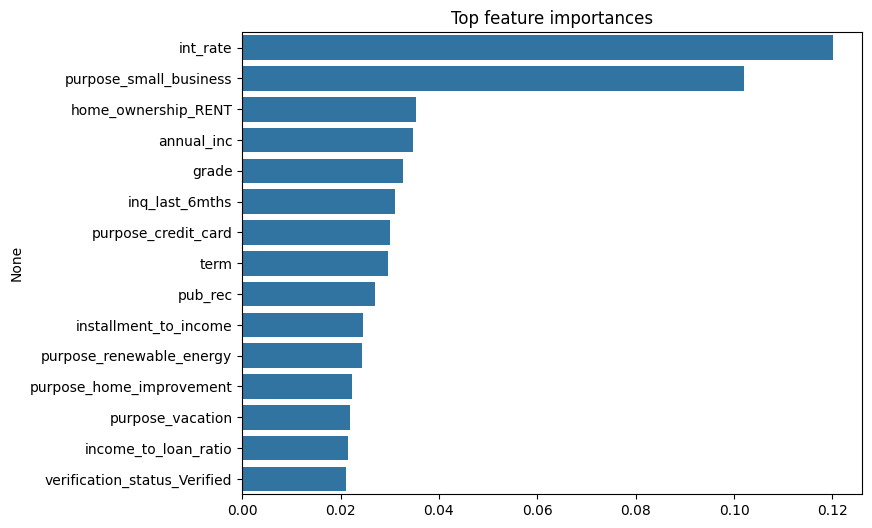


Top features - LogisticRegression


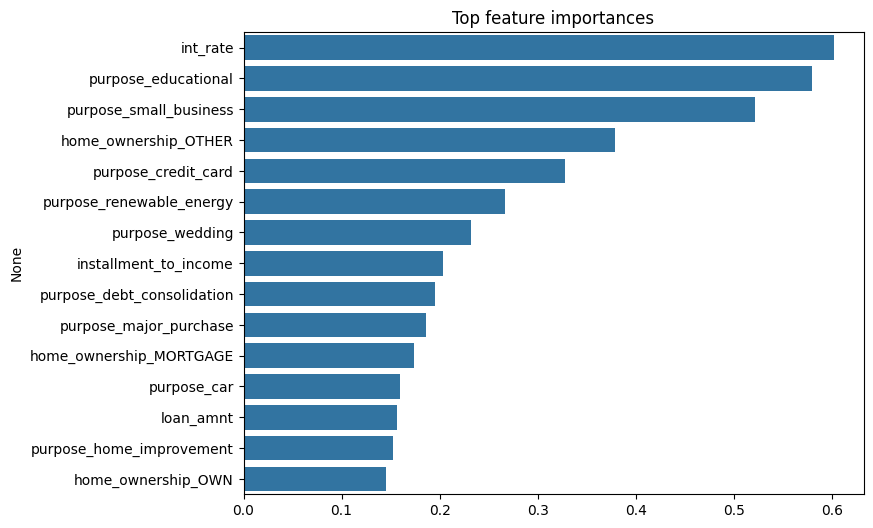

In [ ]:
# -------------------------
# 11. Feature importance
# -------------------------
def show_feature_importance(model, feat_names, top_n=20):
    if hasattr(model, "feature_importances_"):
        imp = model.feature_importances_
    elif hasattr(model, "coef_"):
        imp = np.abs(model.coef_).ravel()
    else:
        print("No feature importance")
        return None
    s = pd.Series(imp, index=feat_names).sort_values(ascending=False).head(top_n)
    plt.figure(figsize=(8,6))
    sns.barplot(x=s.values, y=s.index)
    plt.title("Top feature importances")
    plt.show()
    return s

# Show for RF, XGB, LR
for name in ["RandomForest","XGBoost","LogisticRegression"]:
    print("\nTop features -", name)
    show_feature_importance(results[name]["model"], feature_names, top_n=15)

In [ ]:
# -------------------------
# 12. Summary & conclusion (automatic)
# -------------------------
summary = pd.DataFrame([
    (name, r["accuracy"], r["precision"], r["recall"], r["f1"], r["auc"])
    for name, r in results.items()
], columns=["model","accuracy","precision","recall","f1","auc"]).sort_values(by="auc", ascending=False)

print("\n=== Summary (sorted by AUC) ===")
print(summary)

best = summary.iloc[0]
print(f"\nBest model by AUC: {best['model']} (AUC={best['auc']:.4f}, Recall={best['recall']:.4f}, Precision={best['precision']:.4f})")

print("\n--- Business Conclusion (draft) ---")
print("- Model terbaik berdasarkan AUC:", best["model"])
print("- Implikasi: model ini dapat membantu meningkatkan deteksi peminjam berisiko (meningkatkan Recall), sehingga mengurangi potensi kerugian akibat kredit macet.")
print("- Rekomendasi teknis: lakukan hyperparameter tuning, cross-validation, threshold tuning sesuai toleransi risiko perusahaan, dan uji model pada data nyata (out-of-time).")
print("- Rekomendasi bisnis: gunakan model sebagai alat bantu (scoring), jangan sole decision; kombinasi score + kebijakan bisnis lebih aman.")


=== Summary (sorted by AUC) ===
                model  accuracy  precision    recall        f1       auc
2             XGBoost  0.657540   0.928430  0.665803  0.775484  0.679772
0  LogisticRegression  0.633235   0.930953  0.634150  0.754409  0.679350
1        RandomForest  0.888290   0.888317  0.999963  0.940839  0.668989

Best model by AUC: XGBoost (AUC=0.6798, Recall=0.6658, Precision=0.9284)

--- Business Conclusion (draft) ---
- Model terbaik berdasarkan AUC: XGBoost
- Implikasi: model ini dapat membantu meningkatkan deteksi peminjam berisiko (meningkatkan Recall), sehingga mengurangi potensi kerugian akibat kredit macet.
- Rekomendasi teknis: lakukan hyperparameter tuning, cross-validation, threshold tuning sesuai toleransi risiko perusahaan, dan uji model pada data nyata (out-of-time).
- Rekomendasi bisnis: gunakan model sebagai alat bantu (scoring), jangan sole decision; kombinasi score + kebijakan bisnis lebih aman.
